In [1]:
import numpy as np
data = np.load('Wafer_Map_Datasets\Wafer_Map_Datasets.npz')
data.files

['arr_0', 'arr_1']

In [2]:
data0 = data['arr_0']
data1 = data['arr_1']
data0 = data0[:,np.newaxis,]
data0.shape, data1.shape

((38015, 1, 52, 52), (38015, 8))

In [3]:
import random
datalen = data0.shape[0]
idx = list(range(datalen))
train_idx = random.sample(idx, int(0.8*datalen))
val_idx = list(set(idx)-set(train_idx))
x_train, y_train = data0[train_idx], data1[train_idx]
x_val, y_val = data0[val_idx], data1[val_idx]
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((30412, 1, 52, 52), (30412, 8), (7603, 1, 52, 52), (7603, 8))

In [4]:
import torch.nn as nn
import torch
from torch.nn import functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, shortcut=None):
        super(ResidualBlock,self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,stride,padding=1,bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace = True),#inplace = True原地操作
            nn.Conv2d(out_ch,out_ch,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_ch)
            )
        self.right = shortcut
        
    def forward(self,x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)
        
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18,self).__init__()
        self.pre = nn.Sequential(
                nn.Conv2d(1,64,7,stride=2,padding=3,bias=False),# (224+2*p-)/2(向下取整)+1，size减半->112
                nn.BatchNorm2d(64),#112x112x64
                nn.ReLU(inplace = True),
                nn.MaxPool2d(3,2,1)#kernel_size=3, stride=2, padding=1
                )#56x56x64
        
        self.layer1 = self.make_layer(64,64,2)#56x56x64,layer1层输入输出一样，make_layer里，应该不用对shortcut进行处理，但是为了统一操作。。。
        self.layer2 = self.make_layer(64,128,2,stride=2)#第一个stride=2,剩下3个stride=1;28x28x128
        self.layer3 = self.make_layer(128,256,2,stride=2)#14x14x256
        self.layer4 = self.make_layer(256,512,2,stride=2)#7x7x512
        #分类用的全连接
        self.fc = nn.Linear(512,num_classes)
        
        self.dropout = nn.Dropout(p=0.5)  # dropout训练
        
    def make_layer(self,in_ch,out_ch,block_num,stride=1):
        #当维度增加时，对shortcut进行option B的处理
        shortcut = nn.Sequential(#首个ResidualBlock需要进行option B处理
                nn.Conv2d(in_ch,out_ch,1,stride,bias=False),#1x1卷积用于增加维度；stride=2用于减半size；为简化不考虑偏差
                nn.BatchNorm2d(out_ch)
                )
        layers = []
        layers.append(ResidualBlock(in_ch,out_ch,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(out_ch,out_ch))#后面的几个ResidualBlock,shortcut直接相加
        return nn.Sequential(*layers)
        
    def forward(self,x):  
        x = self.pre(x)   
        x = self.layer1(x)
        x = self.layer2(x) 
        x = self.layer3(x) 
        x = self.layer4(x)
        x = F.avg_pool2d(x,2)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x) 
        return x


In [5]:
from torch.nn import BCELoss
class SigmoidBCELoss(BCELoss):
    def __init__(self):
        super(SigmoidBCELoss, self).__init__()

    def forward(self, outputs, y):
        sigmoid = torch.nn.Sigmoid()
        bce = torch.nn.BCELoss()
        loss = bce(sigmoid(outputs), y)
        return loss

In [6]:
data = torch.rand([1,1,52,52])
model = ResNet18(num_classes=8)
print(model)
# out = model(data)

ResNet18(
  (pre): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (right): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [16]:
from torch.utils.data import DataLoader,TensorDataset
from torch.optim import Adam
from torchvision import transforms
from torch import nn
import torch
import numpy as np
import os
import json
# from tqdm import tqdm

batchsize = 64
epochs = 10

train_loader = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()), batchsize, True, drop_last=True, pin_memory=True)
test_loader = DataLoader(TensorDataset(torch.tensor(x_val).float(),torch.tensor(y_val).float()), batchsize, True, drop_last=True, pin_memory=True)
train_num, test_num = len(train_loader), len(test_loader)

model = ResNet18(num_classes=8)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = Adam(model.parameters(), lr=3e-4)
loss_func = SigmoidBCELoss()
print('start training...')
best_acc = 0.
trainloss, trainacc = [], []
testloss, testacc = [], []
pbar = (range(epochs))
for epoch in pbar:
    model.train()
    losses, accs = [], []
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            batch_images, batch_labels = batch_images.cuda(),batch_labels.cuda()
        out = model(batch_images)
        
        batch_labels = batch_labels.squeeze()
        loss = loss_func(out, batch_labels)

        # prediction = torch.argmax(out,dim=1
        out[out>0.5]=1
        out[out<=0.5]=0

        train_correct = (out == batch_labels).sum() / 8
        ##这里得到的train_correct是一个longtensor型，需要转换为float
        train_acc = (train_correct.float()) / batchsize

        optimizer.zero_grad() #清空梯度信息，否则在每次进行反向传播时都会累加
        loss.backward()  #loss反向传播
        optimizer.step()  ##梯度更新

        losses.append(loss.item())
        accs.append(train_acc.item())
#         if i%20 == 0:
#             pbar.set_description("Epoch: %d/%d || step: %d/%d average_loss: %.3f || train_acc: %.2f"
#               %(epoch, epochs, i, train_num, loss.item(), train_acc.item()))
    trainloss.append(np.mean(np.array(losses)))
    trainacc.append(np.mean(np.array(accs)))
    print("[TRAIN] Epoch: %d/%d || average_loss: %.3f || train_acc: %.2f"
          %(epoch, epochs, np.mean(np.array(losses)), np.mean(np.array(accs))))
    
    model.eval()
    losses, accs = [], []
    for i, (batch_images, batch_labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            batch_images, batch_labels = batch_images.cuda(),batch_labels.cuda()
        with torch.no_grad():
            out = model(batch_images)
        
        batch_labels = batch_labels.squeeze()
        loss = loss_func(out, batch_labels)

        out[out>0.5]=1
        out[out<=0.5]=0

        test_correct = (out == batch_labels).sum() / 8
        ##这里得到的train_correct是一个longtensor型，需要转换为float
        test_acc = (test_correct.float()) / batchsize

        
        losses.append(loss.item())
        accs.append(test_acc.item())
    testloss.append(np.mean(np.array(losses)))
    testacc.append(np.mean(np.array(accs)))
    print("[TEST] Epoch: %d/%d || average_loss: %.3f || test_acc: %.2f"
          %(epoch, epochs, np.mean(np.array(losses)), np.mean(np.array(accs))))
##每10epoch保存一次模型
    if np.mean(np.array(accs)) > best_acc:
        best_acc = np.mean(np.array(accs))
        torch.save(model.state_dict(), 'res18.pth')

start training...
[TRAIN] Epoch: 0/10 || average_loss: 0.117 || train_acc: 0.95
[TEST] Epoch: 0/10 || average_loss: 0.042 || test_acc: 0.99
[TRAIN] Epoch: 1/10 || average_loss: 0.042 || train_acc: 0.99
[TEST] Epoch: 1/10 || average_loss: 0.055 || test_acc: 0.98
[TRAIN] Epoch: 2/10 || average_loss: 0.030 || train_acc: 0.99
[TEST] Epoch: 2/10 || average_loss: 0.027 || test_acc: 0.99
[TRAIN] Epoch: 3/10 || average_loss: 0.023 || train_acc: 0.99
[TEST] Epoch: 3/10 || average_loss: 0.032 || test_acc: 0.99
[TRAIN] Epoch: 4/10 || average_loss: 0.021 || train_acc: 0.99
[TEST] Epoch: 4/10 || average_loss: 0.061 || test_acc: 0.98
[TRAIN] Epoch: 5/10 || average_loss: 0.016 || train_acc: 1.00
[TEST] Epoch: 5/10 || average_loss: 0.027 || test_acc: 0.99
[TRAIN] Epoch: 6/10 || average_loss: 0.015 || train_acc: 1.00
[TEST] Epoch: 6/10 || average_loss: 0.032 || test_acc: 0.99
[TRAIN] Epoch: 7/10 || average_loss: 0.013 || train_acc: 1.00
[TEST] Epoch: 7/10 || average_loss: 0.027 || test_acc: 0.99
[TRAIN

In [17]:
import  torch
print(torch.cuda.is_available())


True


In [18]:
model.eval()
output, gts = [[],[],[],[],[],[],[],[]], [[],[],[],[],[],[],[],[]]
for i, (batch_images, batch_labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        batch_images, batch_labels = batch_images.cuda(),batch_labels.cuda()
    with torch.no_grad():
        out = model(batch_images)

    batch_labels = batch_labels.squeeze()
    loss = loss_func(out, batch_labels)

    out[out>0.5]=1
    out[out<=0.5]=0
    
    for i in range(8):
        # print(i)
        output[i].extend(out[:,i].cpu().data.numpy().tolist())
        gts[i].extend(batch_labels[:,i].cpu().data.numpy().tolist())

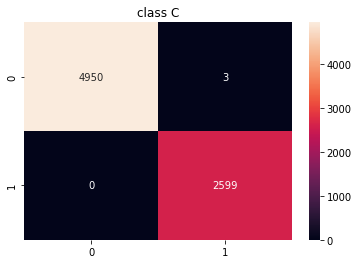

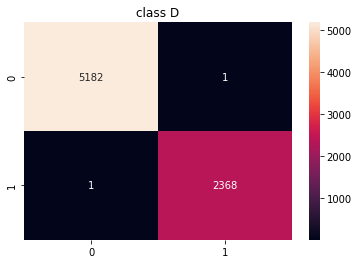

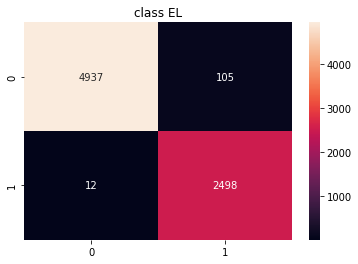

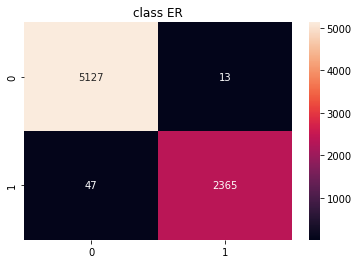

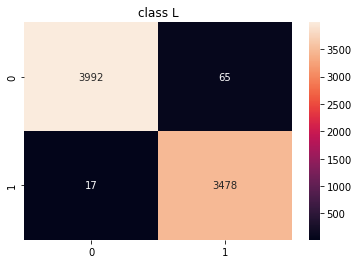

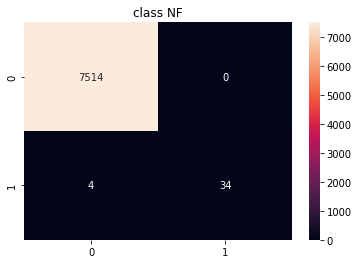

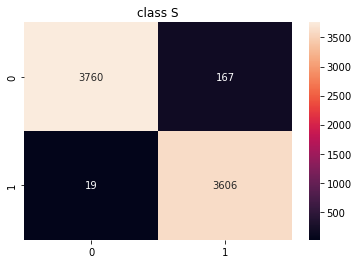

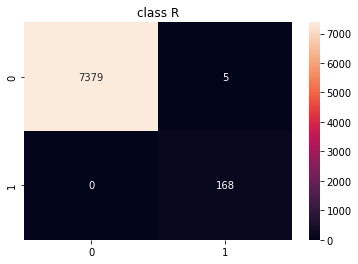

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['C', 'D', 'EL', 'ER', 'L', 'NF', 'S', 'R']
cm = [[],[],[],[],[],[],[],[]]
for i in range(8):
    cm[i] = confusion_matrix(output[i], gts[i])
    plt.figure()
    sns.heatmap(cm[i],annot=True, fmt='d')
    plt.title(f'class {class_names[i]}')

Text(0.5, 1.0, 'acc')

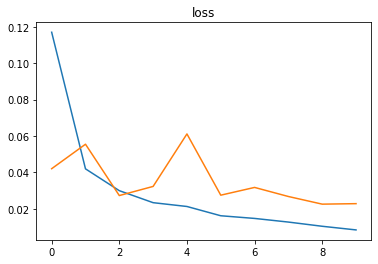

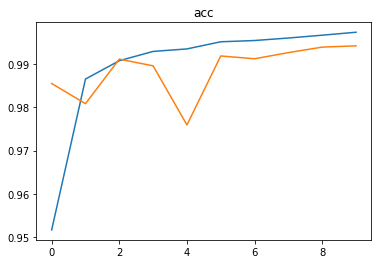

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trainloss)
plt.plot(testloss)
plt.title('loss')

plt.figure()
plt.plot(trainacc)
plt.plot(testacc)
plt.title('acc')